In [1]:
 %matplotlib inline

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.sep.join(['..', '..', 'source']))
sys.path.insert(0, os.sep.join(['..', '..', 'ramp']))

from ramp.seismic_configuration import SeismicSurveyConfiguration, five_n_receivers_array_creator

In [3]:
# Setup directories
data_directory = os.path.join('..', '..', 'data', 'user', 'optimization')
output_directory = os.path.join('..', 'user', 'output', 'optimization_processing')
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

In [4]:
# Define coordinates of sources
num_sources = 9
sources = np.c_[4000 + np.array([240, 680, 1120, 1600, 2040, 2480, 2920, 3400, 3840]),
                np.zeros(num_sources),
                np.zeros(num_sources)]

# Define coordinates of receivers
num_receivers = 101
receivers = np.c_[4000 + np.linspace(0, 4000, num=num_receivers),
                  np.zeros(num_receivers),
                  np.zeros(num_receivers)]

In [5]:
# Create survey configuration with defined coordinates
array_creator_kwargs = {'source_coords': sources,
                        'receiver_coords': receivers}
configuration = SeismicSurveyConfiguration(
    sources, receivers, name='Test Survey', create_arrays=True,
    array_creator=five_n_receivers_array_creator,
    array_creator_kwargs=array_creator_kwargs)

print('Number of created arrays:', configuration.num_arrays)

Number of created arrays: 489


In [6]:
print('Indices of arrays:\n', list(configuration.arrays.keys()))

Indices of arrays:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

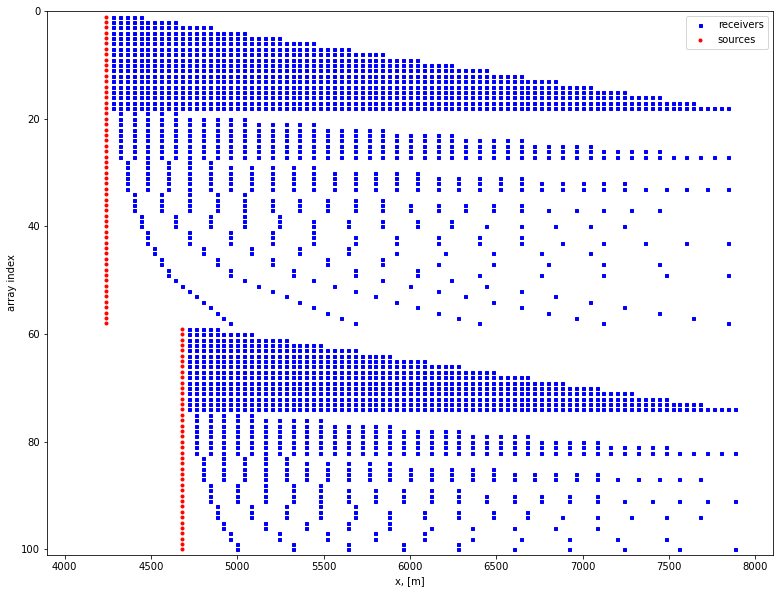

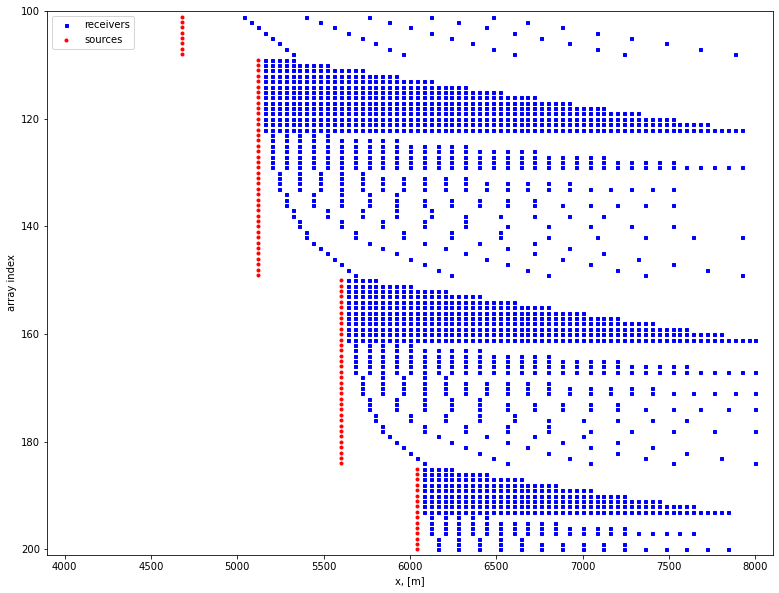

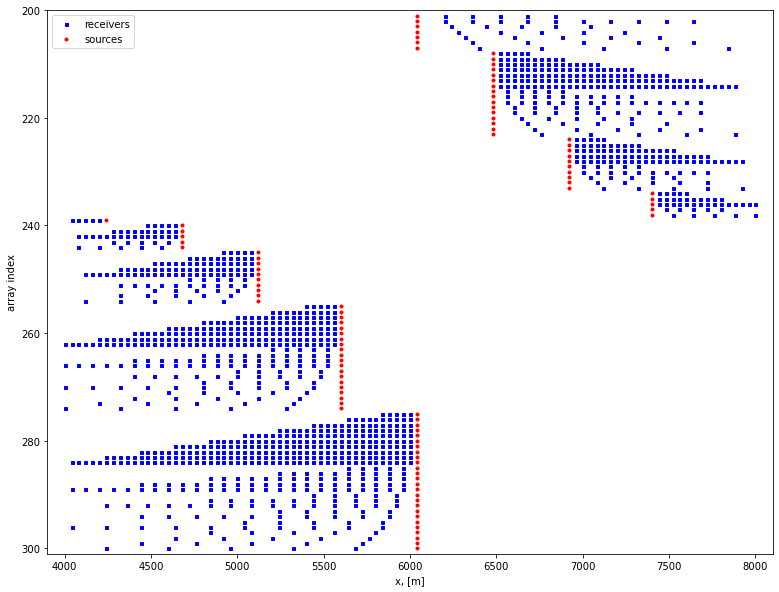

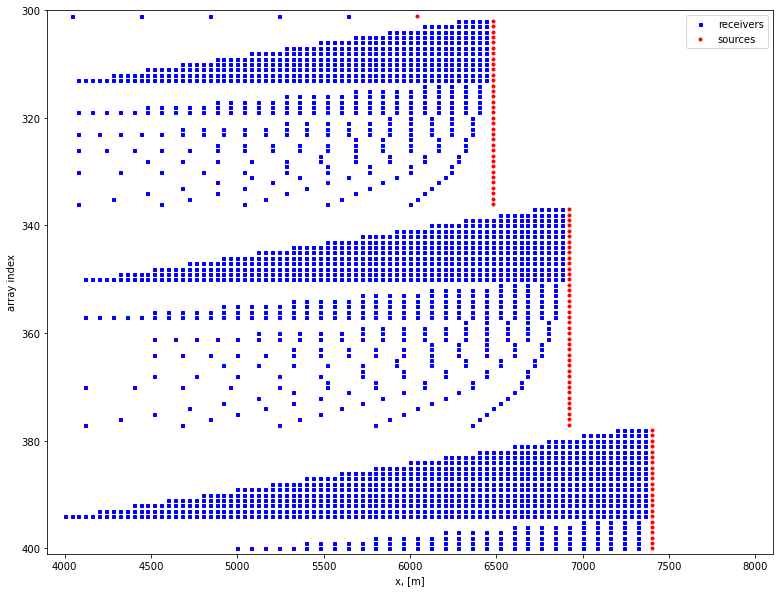

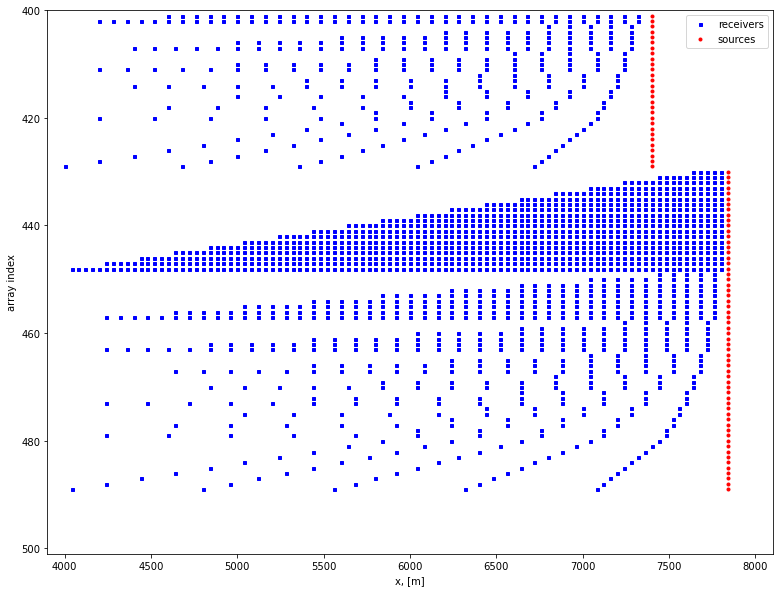

In [7]:
# Plot arrays
for plot_ind in range(5):
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(111)
    init_ind = plot_ind*100
    last_ind = (plot_ind+1)*100-1
    for ind in range(init_ind, last_ind+1):
        if ind in configuration.arrays:
            sind = configuration.arrays[ind]['source']
            rind = configuration.arrays[ind]['receivers']
            nr = configuration.arrays[ind]['num_receivers'] # number of receivers in the array
            if ind == init_ind:
                ax.plot(receivers[rind, 0], nr*[ind+1], 'sb', label='receivers', markersize=3)
                ax.plot([sources[sind, 0]], [ind+1], 'or', label='sources', markersize=3)
            else:
                ax.plot(receivers[rind, 0], nr*[ind+1], 'sb', label=None, markersize=3)
                ax.plot([sources[sind, 0]], [ind+1], 'or', label=None, markersize=3)

    ax.set_xlim(4000-100, 8000+100)
    ax.set_xlabel('x, [m]')
    ax.set_ylim(init_ind, last_ind+2)
    ax.set_ylabel('array index')
    ax.invert_yaxis()
    ax.legend()

In [8]:
# Temporal and spatial coordinates
time_points = 10*np.arange(1, 21)
num_time_points = len(time_points)
excluded = [37, 118, 136, 150, 182, 245] # 6 scenarios
scenarios = list(set(range(1, 307)).difference(excluded))
num_scenarios = len(scenarios)

coordinates = {1: 4000 + 10*np.arange(401),
               2: 10*np.arange(141)}  # 1 is x, 2 is z

In [9]:
# Load NRMS data
nrms_data_file = os.path.join(data_directory, 'nrms_optimization_data_300_scenarios.npz')
d = np.load(nrms_data_file)
# Determine shape of the data
data_shape = d['data'].shape
print(data_shape)  # (300, 20, 9, 101)  scenarios, time points, sources, receivers
nrms = d['data']

(300, 20, 9, 101)


In [10]:
# Setup data that will hold results of processing NRMS data for all created arrays
arrays_nrms = np.zeros((configuration.num_arrays, num_scenarios, num_time_points, 3)) # 3 is for number of largest NRMS values

In [11]:
# Process NRMS data for each array in the set
for array_ind in configuration.arrays:
    sind = configuration.arrays[array_ind]['source']
    rind = configuration.arrays[array_ind]['receivers']
    # Get subset of NRMS data for a given array
    subset_nrms = nrms[:, :, sind, rind]
    # Sort numbers in increasing order
    sorted_subset_nrms = np.sort(subset_nrms)
    # Keep the largest three nrms associated with a given array
    arrays_nrms[array_ind, :, :, :] = sorted_subset_nrms[:, :, -3:]

In [12]:
print(arrays_nrms.shape)

(489, 300, 20, 3)


In [13]:
# Save arrays_nrms data
file_to_save = os.path.join(
    output_directory,
    'arrays_nrms_data_3max_values_{}_scenarios.npz'.format(num_scenarios))
np.savez_compressed(file_to_save, data=arrays_nrms)

In [14]:
sub_arrays_nrms = arrays_nrms[:, :, :, 0]
print(sub_arrays_nrms.shape)

(489, 300, 20)


In [17]:
# Save sub_arrays_nrms data
file_to_save = os.path.join(
    output_directory,
    'arrays_nrms_data_3rd_max_value_{}_scenarios.npz'.format(num_scenarios))
np.savez_compressed(file_to_save, data=sub_arrays_nrms)

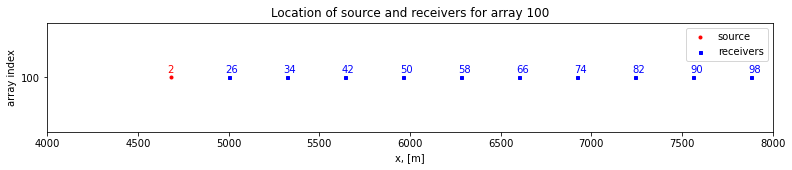

In [14]:
# Take a look at some of the collected data
# Plot array
ind = 99

fig = plt.figure(figsize=(13, 2))
ax = fig.add_subplot(111)
sind = configuration.arrays[ind]['source']
rind = configuration.arrays[ind]['receivers']

nr = configuration.arrays[ind]['num_receivers'] # number of receivers in the array

ax.plot([sources[sind, 0]], [ind+1], 'or', label='source', markersize=3)
ax.plot(receivers[rind, 0], nr*[ind+1], 'sb', label='receivers', markersize=3)

ax.annotate('{}'.format(sind+1), (sources[sind, 0], ind+1),
            xytext=(-3, 5),  # 4 points vertical offset
            textcoords='offset points', color='red')
for rec_ind in range(nr):
    ax.annotate('{}'.format(rind[rec_ind]+1), (receivers[rind[rec_ind], 0], ind+1),
            xytext=(-3, 5),  # 4 points vertical offset
            textcoords='offset points', color='blue')

ax.set_xlim(4000, 8000)
ax.set_xlabel('x, [m]')
ax.set_yticks([ind+1], labels=[ind+1])
ax.set_ylabel('array index')
ax.legend()
ax.set_title('Location of source and receivers for array {}'.format(ind+1));


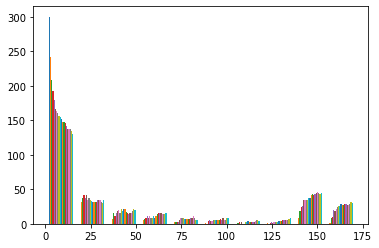

In [15]:
# Plot histogram of the third largest NRMS values for a given array
ind = 99
proc_data = arrays_nrms[ind, :, :, 0]  # 0 corresponds to the 3rd largest NRMS
plt.hist(proc_data);

In [16]:
# Define NRMS threshold
nrms_threshold = 5

In [17]:
# Check how many scenarios and time points have NRMS larger than the threshold
zeros_ones_arrays = np.zeros(arrays_nrms.shape)
zeros_ones_arrays[arrays_nrms >= nrms_threshold] = 1

In [18]:
# Check the data corresponding to the 3rd largest nrms
ind = 99
print(zeros_ones_arrays[ind, :, :, 0])

[[0. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]


In [19]:
# Calculate probability of detection for each array developing in time
detection_prob = np.zeros((configuration.num_arrays, num_time_points))
for array_ind in configuration.arrays:
    detection_prob[array_ind] = np.sum(zeros_ones_arrays[array_ind, :, :, 0], axis=0)/num_scenarios

In [20]:
detection_prob[array_ind]

array([0.        , 0.15333333, 0.22666667, 0.29      , 0.33333333,
       0.37      , 0.39      , 0.42      , 0.45333333, 0.47333333,
       0.48      , 0.50666667, 0.55      , 0.57666667, 0.58333333,
       0.60333333, 0.61333333, 0.62      , 0.62666667, 0.64333333])

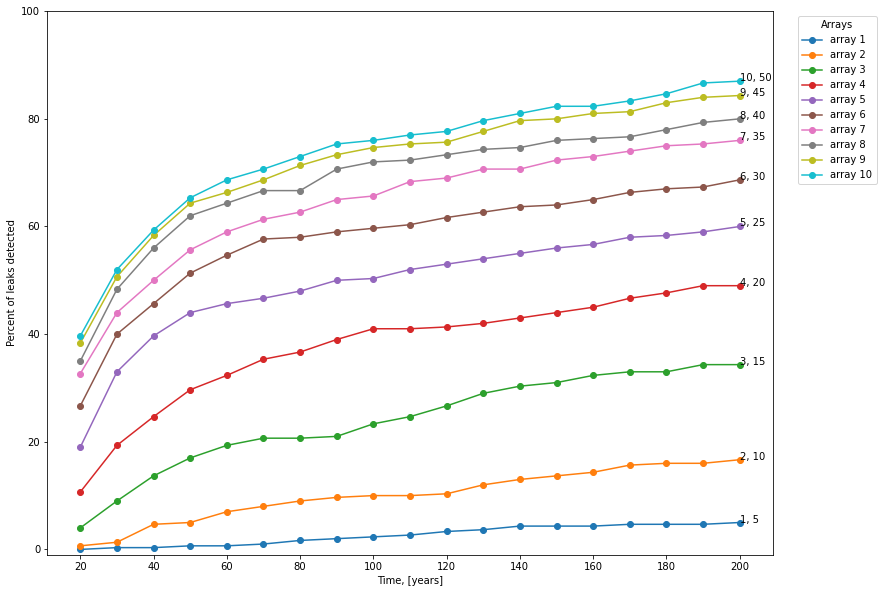

In [21]:
# Plot probability of detection for several arrays
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
for array_ind in range(10):
    ax.plot(time_points[1:], 100*detection_prob[array_ind, 1:], '-o', label='array {}'.format(array_ind+1))
    ax.annotate('{}, {}'.format(array_ind+1, configuration.arrays[array_ind]['num_receivers']),
                (time_points[-1], 100*detection_prob[array_ind, -1]))
ax.legend(ncol=1, title='Arrays', loc='upper right', bbox_to_anchor=(1.15, 1))
ax.set_xlabel('Time, [years]')
ax.set_ylabel('Percent of leaks detected')
ax.set_ylim(-1, 100)
ax.set_xticks(20*np.arange(10)+20);

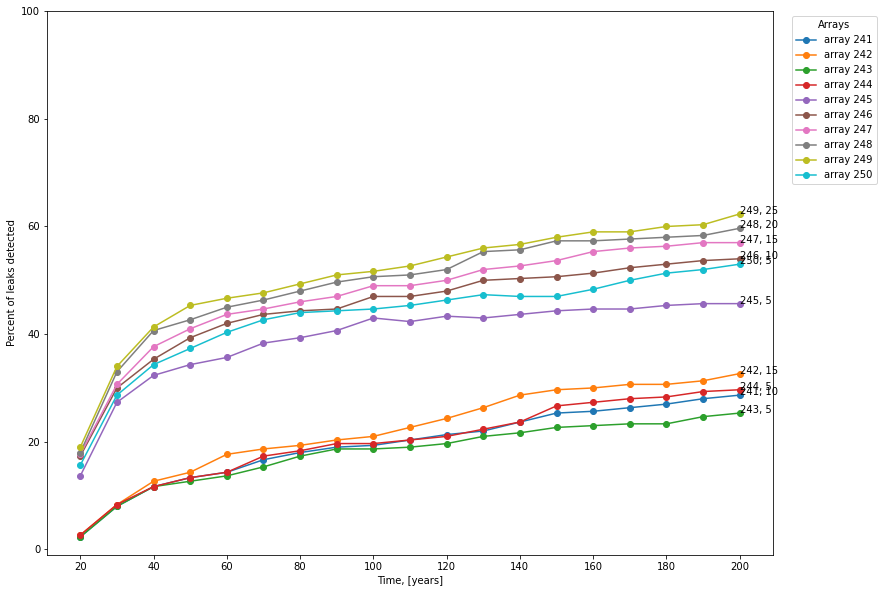

In [22]:
# Plot probability of detection for several arrays
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
for array_ind in range(240, 250):
    ax.plot(time_points[1:], 100*detection_prob[array_ind, 1:], '-o', label='array {}'.format(array_ind+1))
    ax.annotate('{}, {}'.format(array_ind+1, configuration.arrays[array_ind]['num_receivers']),
                (time_points[-1], 100*detection_prob[array_ind, -1]))
ax.legend(ncol=1, title='Arrays', loc='upper right', bbox_to_anchor=(1.15, 1))
ax.set_xlabel('Time, [years]')
ax.set_ylabel('Percent of leaks detected')
ax.set_ylim(-1, 100)
ax.set_xticks(20*np.arange(10)+20);

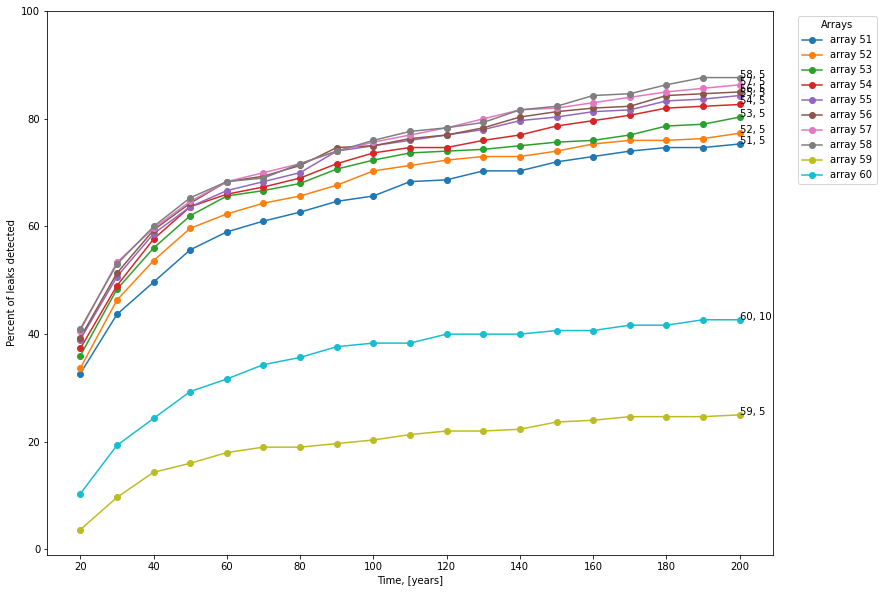

In [23]:
# Plot probability of detection for several arrays
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
for array_ind in range(50, 60):
    ax.plot(time_points[1:], 100*detection_prob[array_ind, 1:], '-o', label='array {}'.format(array_ind+1))
    ax.annotate('{}, {}'.format(array_ind+1, configuration.arrays[array_ind]['num_receivers']),
                (time_points[-1], 100*detection_prob[array_ind, -1]))
ax.legend(ncol=1, title='Arrays', loc='upper right', bbox_to_anchor=(1.15, 1))
ax.set_xlabel('Time, [years]')
ax.set_ylabel('Percent of leaks detected')
ax.set_ylim(-1, 100)
ax.set_xticks(20*np.arange(10)+20);

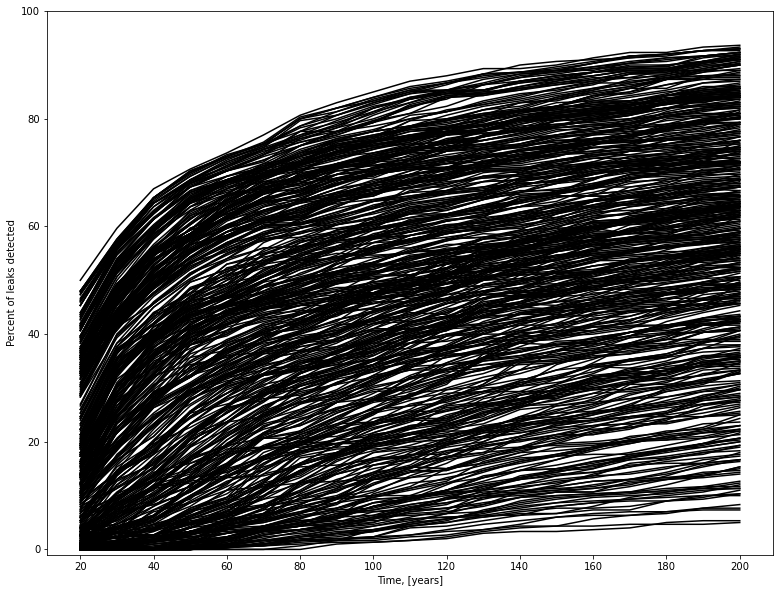

In [24]:
# Plot probability of detection for all arrays
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
for array_ind in configuration.arrays:
    ax.plot(time_points[1:], 100*detection_prob[array_ind, 1:], '-k', label='array {}'.format(array_ind+1))
ax.set_xlabel('Time, [years]')
ax.set_ylabel('Percent of leaks detected')
ax.set_ylim(-1, 100)
ax.set_xticks(20*np.arange(10)+20);

In [25]:
# Get number of receivers for each array
arrays_num_receivers = np.zeros(configuration.num_arrays)
for array_ind in configuration.arrays:
    arrays_num_receivers[array_ind] = configuration.arrays[array_ind]['num_receivers']

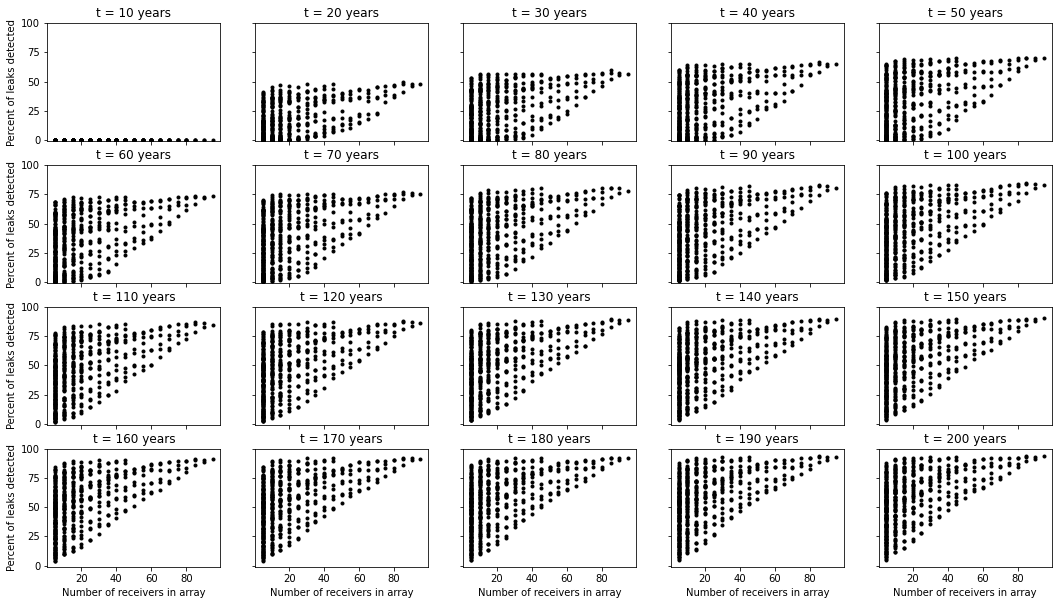

In [26]:
# Plot arrays performance with respect to probability of detection
# y-axis - probability of detection; x-axis - number of receivers
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 10),
                        sharex=True, sharey=True)
for tind, tp in enumerate(time_points):
    row = tind//5
    col = tind%5
    axs[row, col].plot(arrays_num_receivers, 100*detection_prob[:, tind], 'ok', markersize=3)
    axs[row, col].set_title('t = {} years'.format(tp))
    
for row in range(4):
    axs[row, 0].set_ylabel('Percent of leaks detected')
    axs[row, 0].set_ylim(-1, 100);
for col in range(5):
    axs[3, col].set_xlabel('Number of receivers in array')

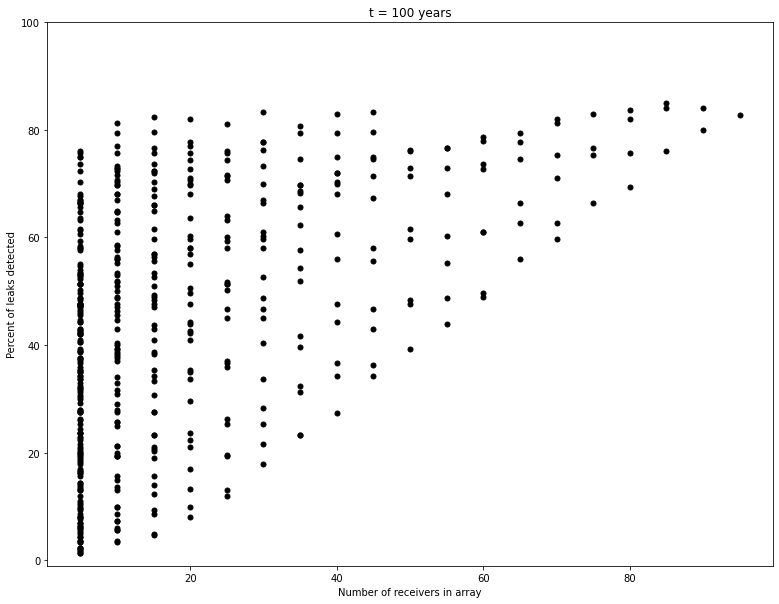

In [27]:
# Plot arrays performance with respect to probability of detection at selected time point
# y-axis - probability of detection; x-axis - number of receivers
tind = 9
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
ax.plot(arrays_num_receivers, 100*detection_prob[:, tind], 'ok', markersize=5)
ax.set_title('t = {} years'.format(time_points[tind]))
ax.set_ylabel('Percent of leaks detected')
ax.set_ylim(-1, 100);
ax.set_xlabel('Number of receivers in array');